In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load required data
returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)
weights_df = pd.read_csv("../data/optimized_weights_ml.csv", index_col=0)
predicted_returns = pd.read_csv("../data/predicted_returns.csv", index_col=0)

In [16]:
# Align data
returns = returns[weights_df.index]
assets = returns.columns

# Define rebalancing parameters
rebalance_period = 30  # rebalance every 30 days
initial_value = 1_000_000  # starting portfolio value

# Initialize portfolio values
dates = returns.index[::rebalance_period]
portfolio_eq = [initial_value]
portfolio_opt = [initial_value]
equal_weight = np.repeat(1 / len(assets), len(assets))

# Store full portfolio history
eq_curve = []
opt_curve = []

In [17]:
# Backtesting loop
for i in range(len(dates) - 1):
    start, end = dates[i], dates[i + 1]
    window = returns.loc[start:end]

    # Equal-weighted strategy
    eq_returns = (window @ equal_weight).dropna()
    eq_growth = (1 + eq_returns).cumprod() * portfolio_eq[-1]
    portfolio_eq.append(eq_growth.iloc[-1])
    eq_curve.extend(eq_growth.tolist())

    # ML-optimized strategy
    opt_weight = weights_df.loc[assets]['Weight'].values
    opt_returns = (window @ opt_weight).dropna()
    opt_growth = (1 + opt_returns).cumprod() * portfolio_opt[-1]
    portfolio_opt.append(opt_growth.iloc[-1])
    opt_curve.extend(opt_growth.tolist())

# Format results
portfolio_perf = pd.DataFrame({
    "Date": returns.index[:len(opt_curve)],
    "Equal Weight": eq_curve[:len(returns)],
    "Optimized ML": opt_curve[:len(returns)]
}).set_index("Date")

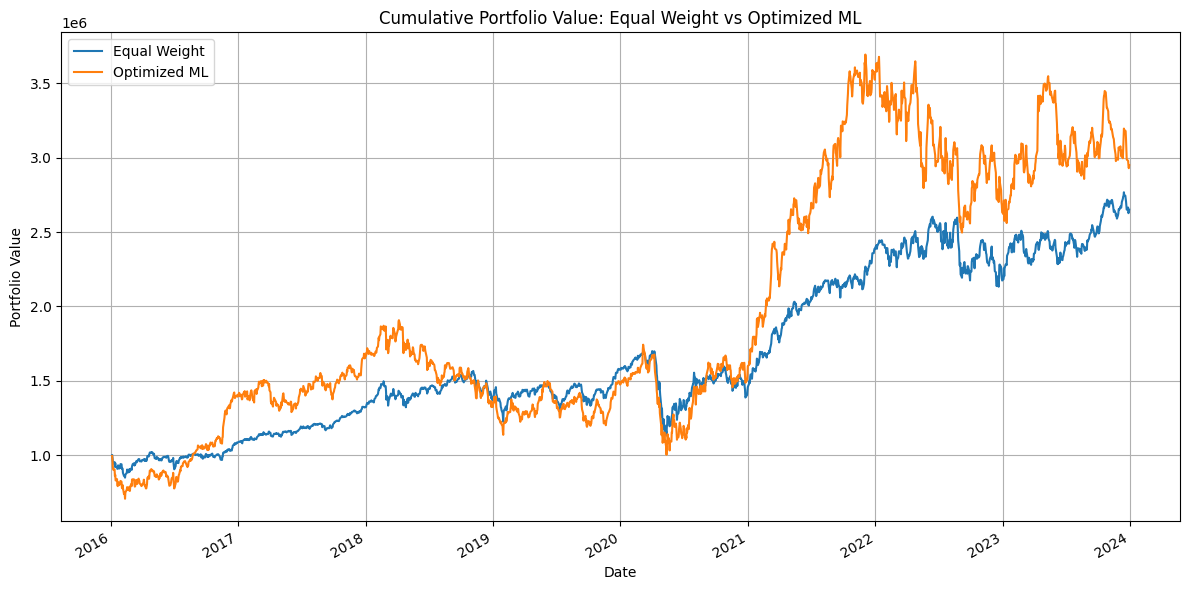

In [18]:
# Plot cumulative performance
plt.figure(figsize=(12, 6))
portfolio_perf.plot(ax=plt.gca())
plt.title("Cumulative Portfolio Value: Equal Weight vs Optimized ML")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
def calculate_metrics(series):
    returns = series.pct_change().dropna()
    cagr = (series.iloc[-1] / series.iloc[0]) ** (252 / len(series)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    downside = returns[returns < 0]
    sortino = returns.mean() / downside.std() * np.sqrt(252)
    max_dd = (series / series.cummax() - 1).min()

    return pd.Series({
        "CAGR": cagr,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown": max_dd,
        "Annual Volatility": volatility
    })


In [20]:
# Evaluate both strategies
metrics_eq = calculate_metrics(portfolio_perf["Equal Weight"])
metrics_ml = calculate_metrics(portfolio_perf["Optimized ML"])

# Combine and display
metrics_df = pd.concat([metrics_eq, metrics_ml], axis=1)
metrics_df.columns = ["Equal Weight", "Optimized ML"]

print("\n📊 Strategy Performance Comparison:")
display(metrics_df.round(4))


📊 Strategy Performance Comparison:


,Equal Weight,Optimized ML
CAGR,0.1301,0.1460
Sharpe Ratio,0.7463,0.6128
Sortino Ratio,0.9815,0.9455
Max Drawdown,-0.3338,-0.4745
Annual Volatility,0.1876,0.2921


In [21]:
# Save results
portfolio_perf.to_csv("../data/portfolio_backtest.csv")
metrics_df.to_csv("../data/performance_metrics.csv")
print("✅ Saved performance results to ../data/")


✅ Saved performance results to ../data/
